# CS 328 Narrative Writing

This is our submission for the writing assignment for **CS 328: Introduction to Data Science**.
Our team members are:
- **Jiya Desai**: 22110107
- **Viraj Vekaria**: 22110287
- **Sujal Patel** : 22110261

### About the Dataset


This is an exploratory study done on the world inequality dataset provided on https://wid.world .

The dataset itself provided a wealth of information about several financial and inequality indicators for different countries and regions. Some key indicators include:
- **GDP per capita**: A measure of a country's economic output that accounts for its number of people.
- **Gini index**: A measure of income inequality within a population, ranging from 0 (perfect equality) to 1 (perfect inequality).
- **Net national income**: The total income of a country's residents, including wages, profits, rents, and taxes, minus subsidies.
- **Net Wealth**: The total value of a country's assets, including real estate and financial assets, minus liabilities.
- **Top 1% share**: The share of total income or wealth held by the top 1% of the population.
- **Top 10% share**: The share of total income or wealth held by the top 10% of the population.
- **Bottom 50% share**: The share of total income or wealth held by the bottom 50% of the population.

---

## Setup

### Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import os
from tqdm import tqdm
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from plotly.subplots import make_subplots
import matplotlib as mpl
from linearmodels.panel import PanelOLS, RandomEffects, compare
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')


# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### Data

In [18]:
# File paths
file_income = "WID_data/WID_Data_Average_National_Income.csv"
file_national_income = "WID_data/WID_Data_National_Income.csv"
file_net_personal_wealth = "WID_data/WID_Data_Net_Personal_Wealth.csv"
file_wealth_inequality = "WID_data/WID_Data_Wealth_Gini_Coeff.csv"
file_income_inequality = "WID_data/WID_Data_Income_Gini_Coeff.csv"
file_wealth_to_income = "WID_data/WID_Data_Net_National_Wealth_To_Net_National_Income_Ratio.csv"
file_GDP = "WID_data/WID_Data_GDP.csv"
file_population = "WID_data/WID_Data_Population.csv"

# Read the datasets
df_income_wealth = pd.read_csv(file_income, header=1, sep=';')
df_wealth_inequality = pd.read_csv(file_wealth_inequality, header=1, sep=';')
df_income_inequality = pd.read_csv(file_income_inequality, header=1, sep=';')
df_wealth_to_income = pd.read_csv(file_wealth_to_income, header=1, sep=';')
df_GDP = pd.read_csv(file_GDP, header=1, sep=';')
df_population = pd.read_csv(file_population, header=1, sep=';')
df_net_wealth = pd.read_csv(file_net_personal_wealth, header=1, sep=';')
df_national_income = pd.read_csv(file_national_income, header=1, sep=';')

In [19]:

# Define a reshaping function
def reshape_wid(df, value_column_name):
    df_long = df.melt(id_vars=['Percentile', 'Year'], var_name='Country', value_name=value_column_name)
    df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
    df_long['Country'] = df_long['Country'].str.strip()
    
    # Prefer 'pall', else take 'p90p100'
    if 'pall' in df_long['Percentile'].unique():
        df_long = df_long[df_long['Percentile'] == 'pall']
    else:
        df_long = df_long[df_long['Percentile'] == 'p90p100']
        
    return df_long.drop(columns=['Percentile'])

# Reshape and clean all datasets
df_income_long = reshape_wid(df_income_wealth, 'PerAdultIncome')
df_wealth_ineq_long = reshape_wid(df_wealth_inequality, 'WealthInequality')
df_income_ineq_long = reshape_wid(df_income_inequality, 'IncomeInequality')
df_wealth_to_income_long = reshape_wid(df_wealth_to_income, 'WealthToIncomeRatio')
df_GDP_long = reshape_wid(df_GDP, 'GDP')
df_population_long = reshape_wid(df_population, 'Population')
df_net_wealth_long = reshape_wid(df_net_wealth, 'NetPersonalWealth')
df_national_income_long = reshape_wid(df_national_income, 'NationalIncome')

# Merge all datasets on ['Country', 'Year']
dfs_to_merge = [
    df_income_long,
    df_wealth_ineq_long,
    df_income_ineq_long,
    df_wealth_to_income_long,
    df_GDP_long,
    df_population_long,
    df_net_wealth_long,
    df_national_income_long
]

from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='inner'), dfs_to_merge)

# Final diagnostic
print("Merged DataFrame:")
print(df_merged.head())
print("Shape:", df_merged.shape)
print("Columns:", df_merged.columns.tolist())
df_merged.to_csv("merged_dataset.csv", index=False)

Merged DataFrame:
   Year    Country  PerAdultIncome  WealthInequality  IncomeInequality  WealthToIncomeRatio        GDP  Population  NetPersonalWealth  NationalIncome
0  1995  Argentina      32274.1540            0.6419            0.6419             3.355870  3246941.8    35070020             0.6186      21577.3592
1  1996  Argentina      33500.0116            0.6419            0.6419             3.358287  3383565.3    35513793             0.6186      22396.9085
2  1997  Argentina      35821.4993            0.6419            0.6419             3.330600  3613854.8    35947791             0.6186      23948.7617
3  1998  Argentina      36560.4663            0.6419            0.6419             3.415269  3709134.5    36372860             0.6187      24442.7282
4  1999  Argentina      34567.7028            0.6419            0.6419             3.471241  3542473.8    36794682             0.6186      23110.5914
Shape: (1479, 10)
Columns: ['Year', 'Country', 'PerAdultIncome', 'WealthInequality

---

## Introduction

### Trends of the share of the top 1%, top 10%, middle 40% and bottom 50% of the total population of a country in the total national income of the top 10 countries with the highest national income (in 2023)

1. United States of America

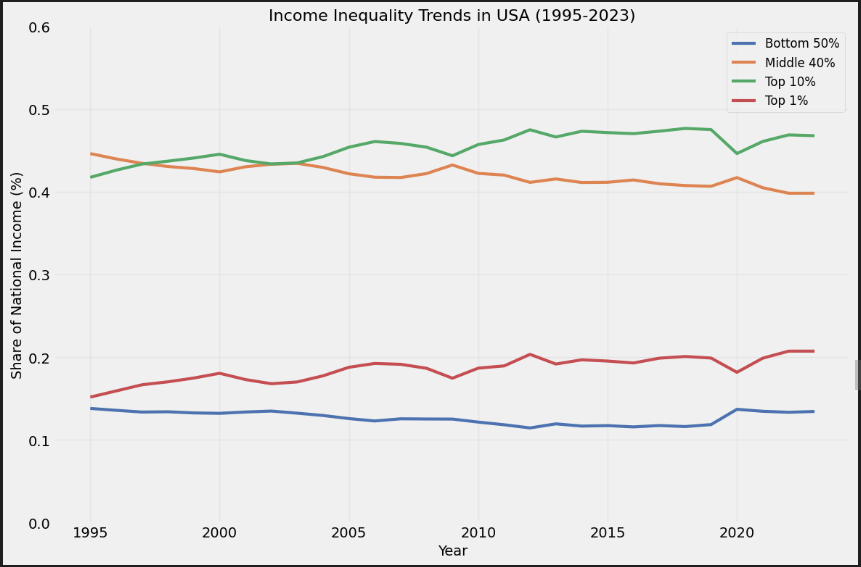

2. China

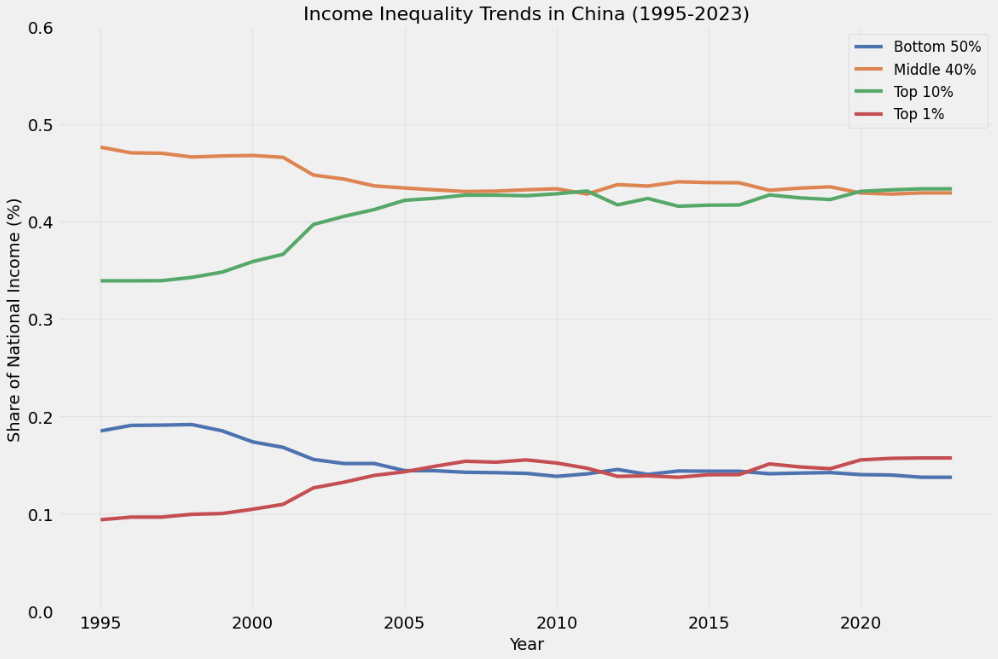

3. Germany

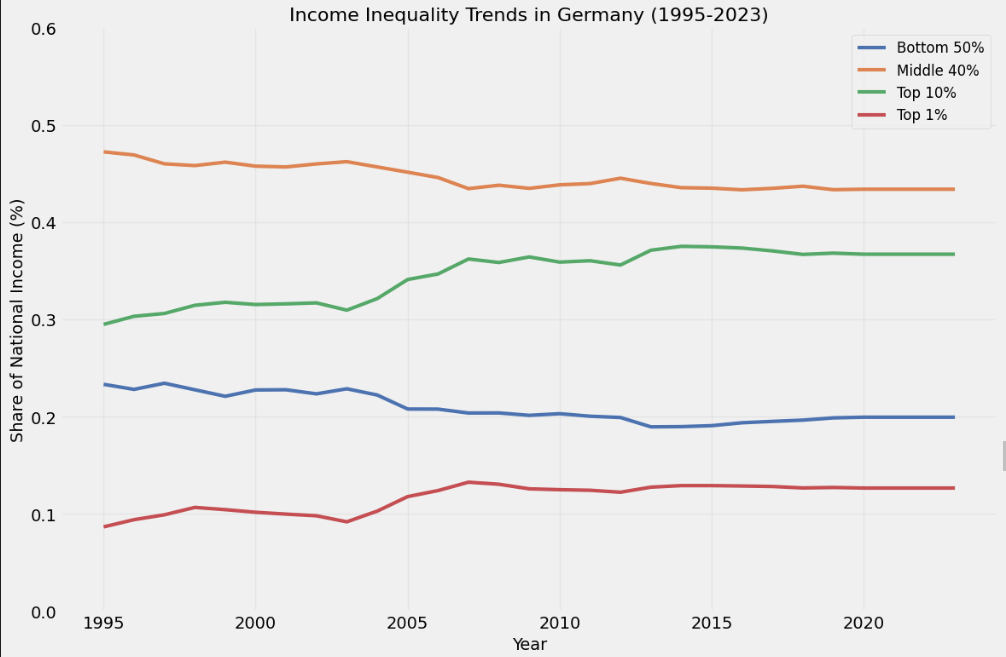

4. Japan

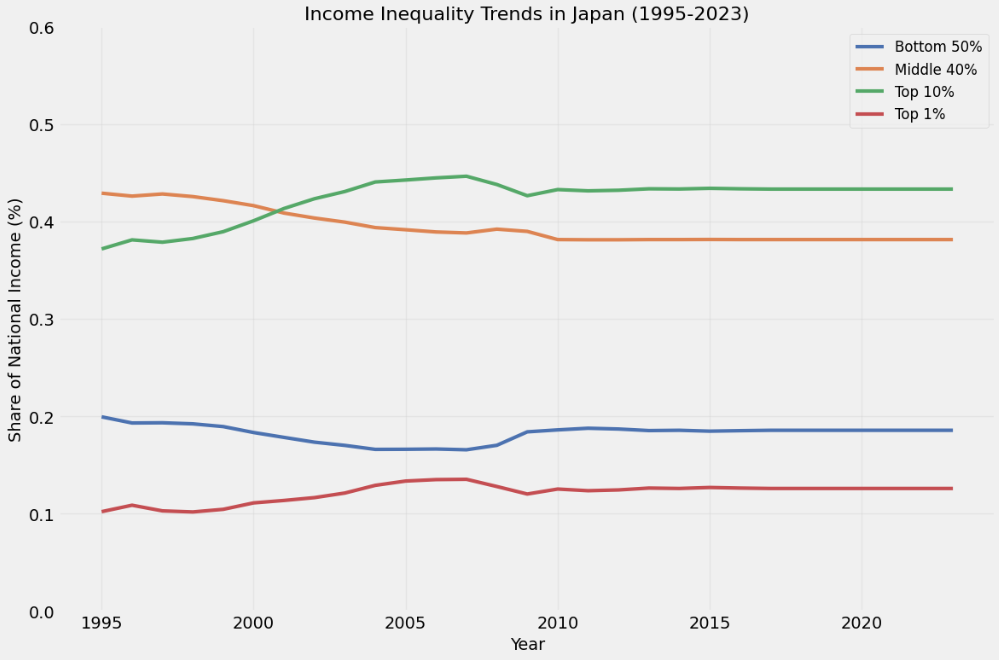

5. India

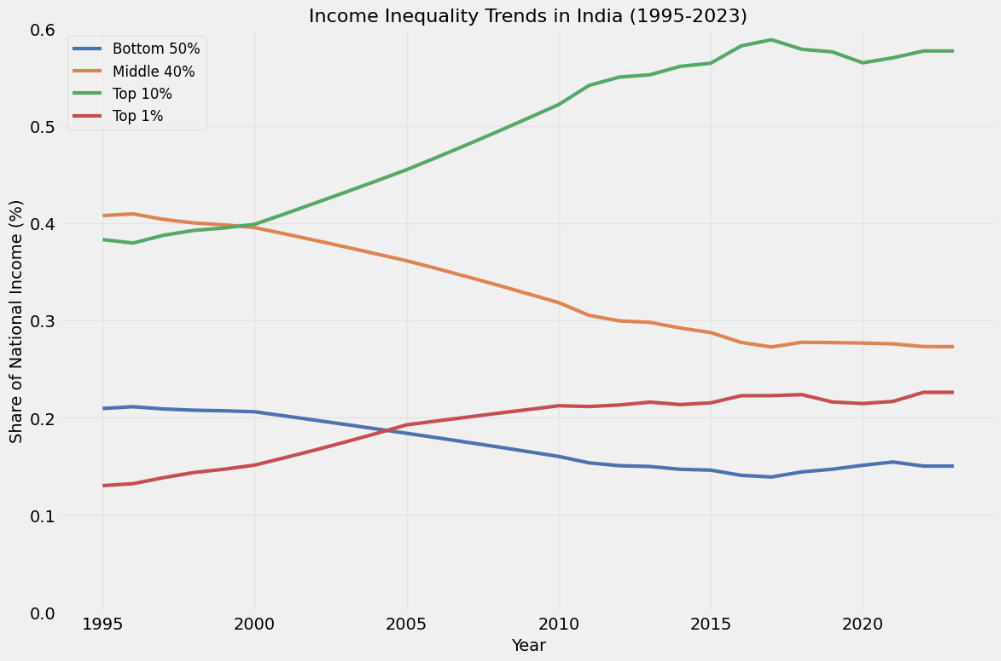

6. United Kingdom

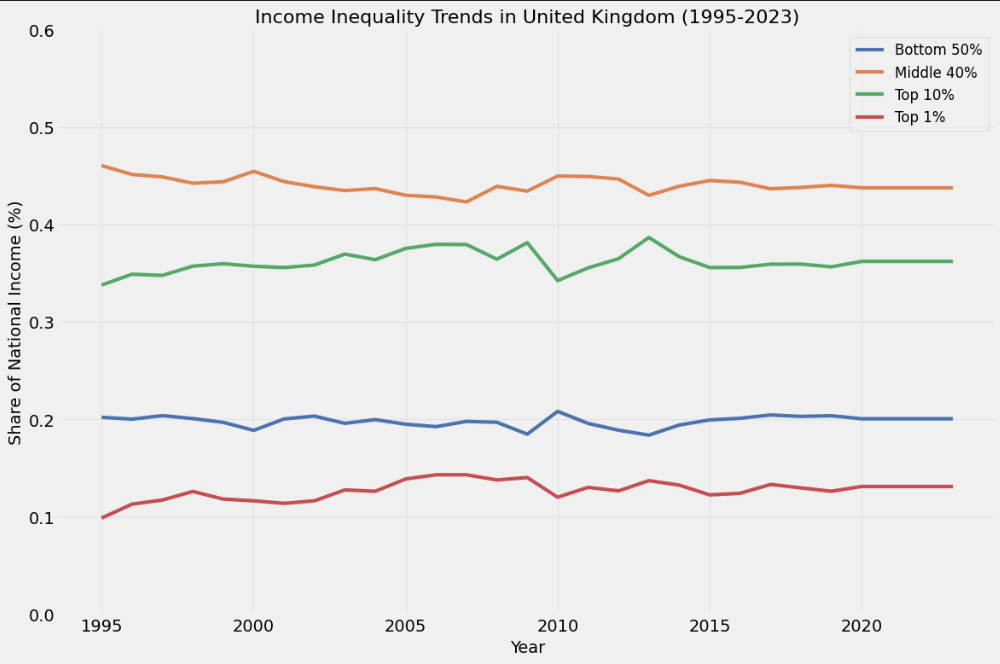

7. France

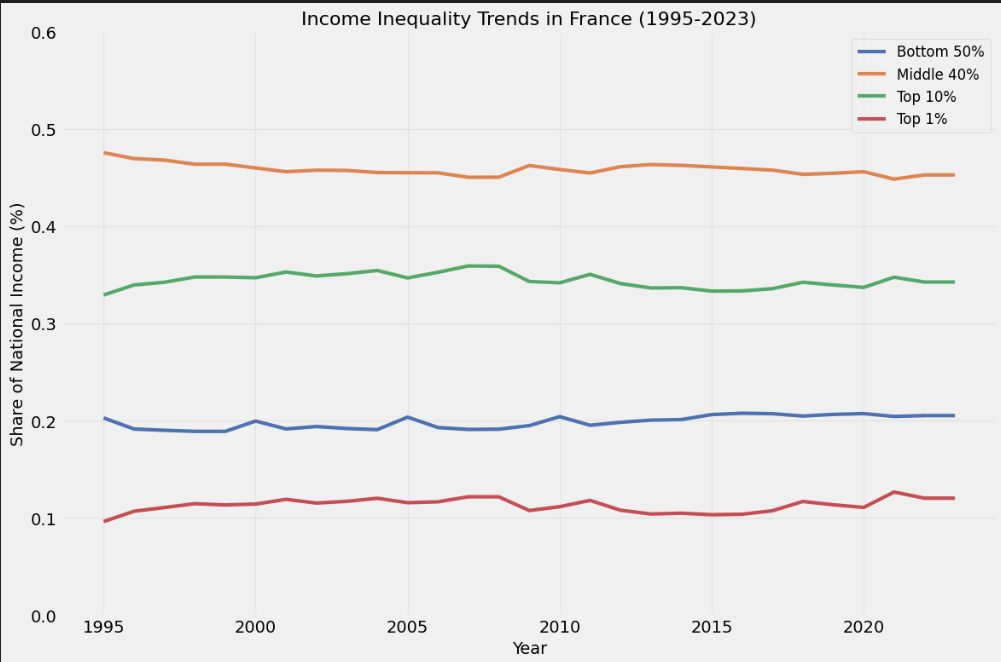

8. Italy

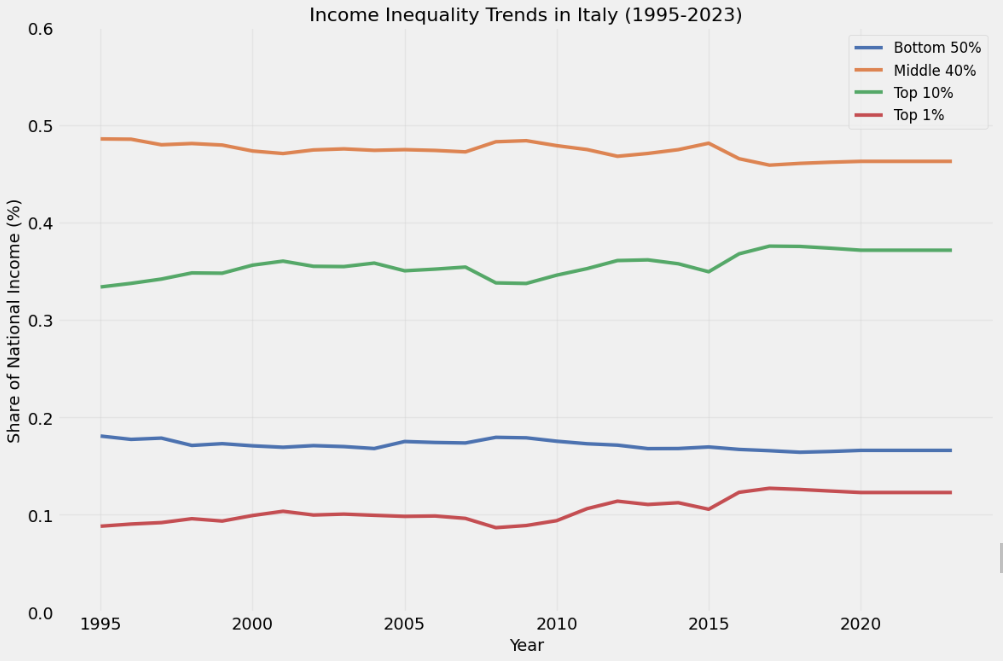

9. Brazil

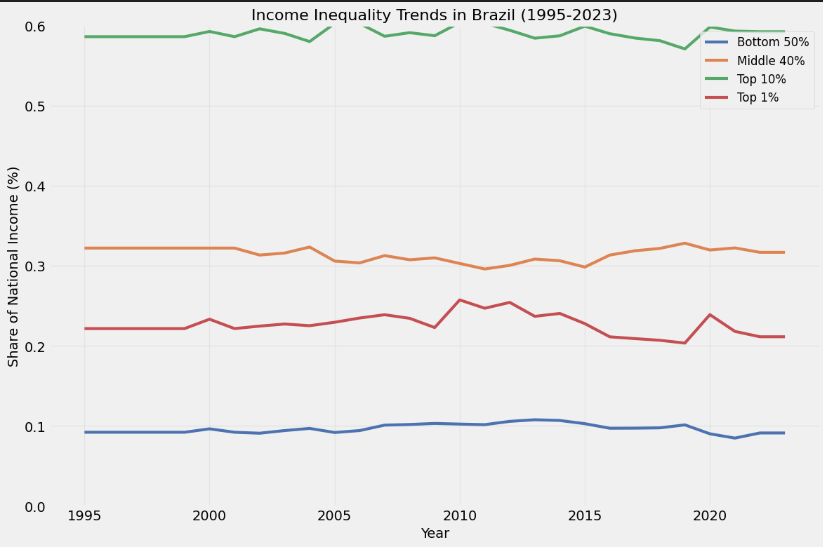

10. Canada

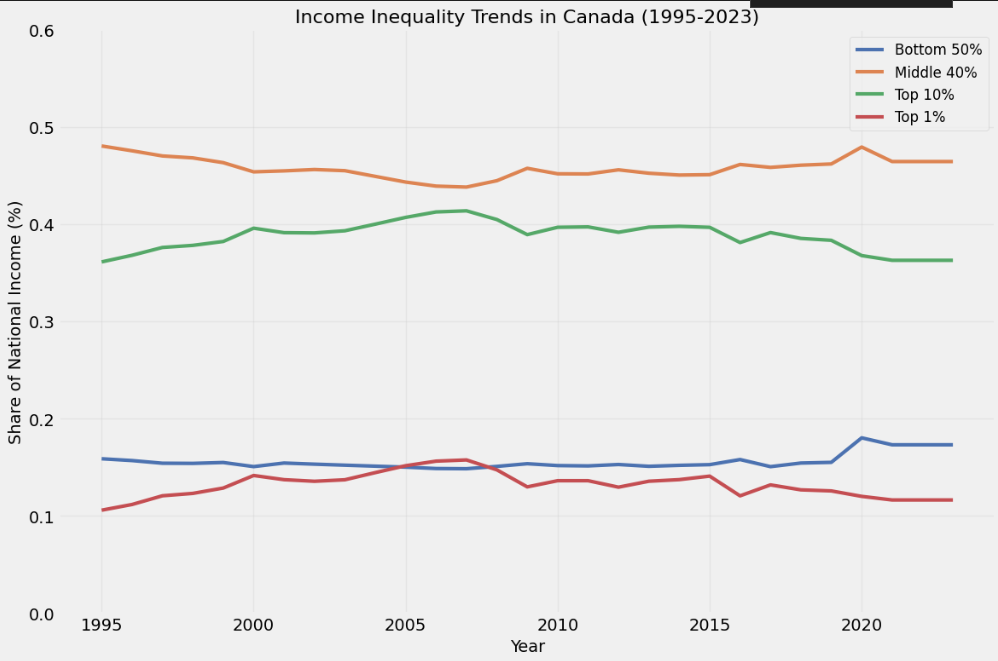

## Hypothesis 1: Does Wealth Breed Inequality? Exploring the Link Between National Income and Economic Disparity

While higher national income is often associated with improved living standards, it does not necessarily translate to equitable wealth and income distribution among a country's population. In fact, some of the world’s wealthiest nations also exhibit stark disparities between their richest and poorest citizens.

This analysis investigates the hypothesis that national income and national inequality are negatively correlated, suggesting that as countries grow richer, a disproportionate share of income and wealth may become concentrated in the hands of a few. In this context, "national inequality" is evaluated through both the share of income held by different population segments (top 1%, top 10%, mid 40%, and bottom 50%) and the Gini index, a widely-used statistical measure of income distribution.

To explore this hypothesis, we employ a two-pronged approach:

- We analyze the temporal trends in income share distribution across the top 10 countries with the highest national income, tracking how inequality evolves over time within the wealthiest nations.

- We plot Gini index values against per-adult national income across countries and years, with each data point weighted by the respective country’s population size, to capture both relative inequality and global impact.

These visualizations aim to reveal whether economic growth correlates with broader prosperity or whether it reinforces structural disparities. Through this lens, we interrogate whether wealthier nations are indeed more unequal—and, crucially, how this inequality manifests over time and across different income groups.

### Preliminary Visualisations: Global trends of average income inequality and average per-adult income over time:

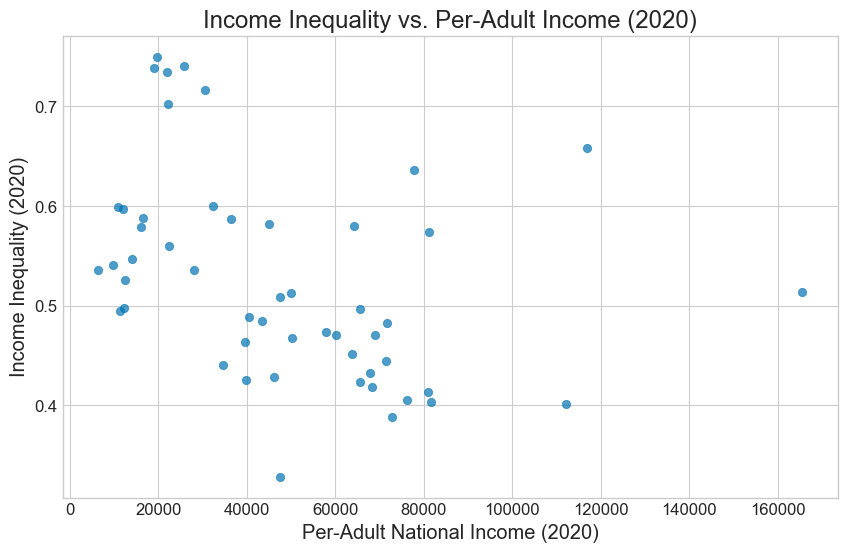

Correlation between Per-Adult Income and Income Inequality: -0.3732727378845258
                            OLS Regression Results                            
Dep. Variable:       IncomeInequality   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     7.933
Date:                Wed, 23 Apr 2025   Prob (F-statistic):            0.00698
Time:                        19:26:20   Log-Likelihood:                 48.002
No. Observations:                  51   AIC:                            -92.00
Df Residuals:                      49   BIC:                            -88.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

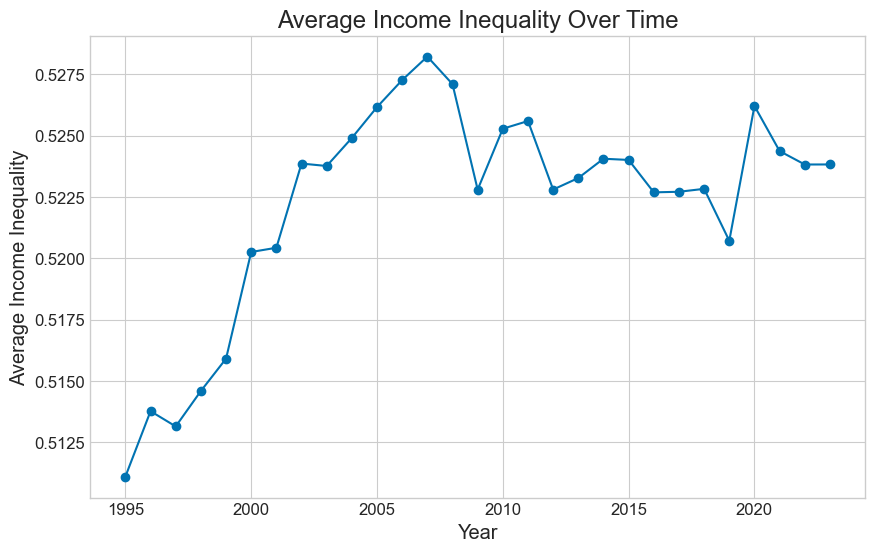

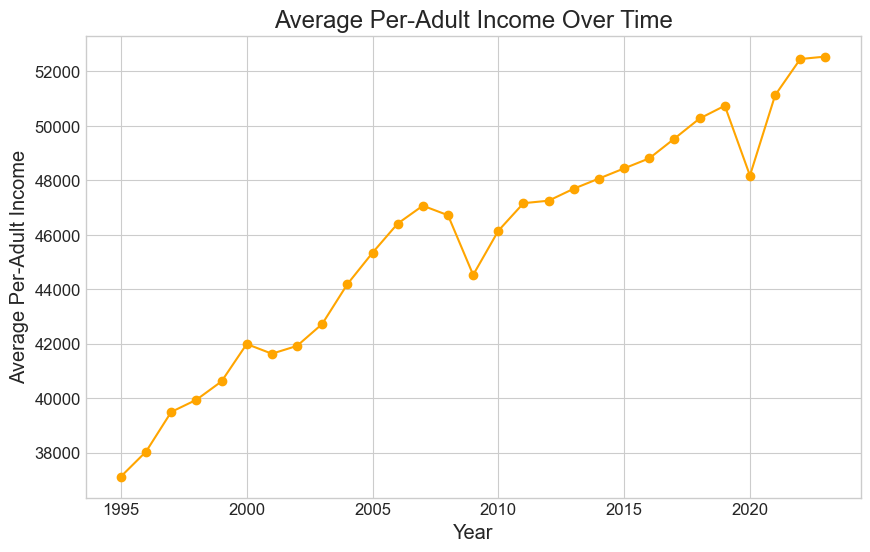

In [20]:
# 1. Scatter plot for Income Inequality vs Per-Adult Income for 2020
df_2020 = df_merged[df_merged['Year'] == 2020].copy()
plt.figure(figsize=(10, 6))
plt.scatter(df_2020['PerAdultIncome'], df_2020['IncomeInequality'], alpha=0.7)
plt.xlabel("Per-Adult National Income (2020)")
plt.ylabel("Income Inequality (2020)")
plt.title("Income Inequality vs. Per-Adult Income (2020)")
plt.grid(True)
plt.show()

# 2. Calculate Pearson correlation
corr_h1 = df_2020['PerAdultIncome'].corr(df_2020['IncomeInequality'])
print("Correlation between Per-Adult Income and Income Inequality:", corr_h1)

# 3. Regression model
X = sm.add_constant(df_2020['PerAdultIncome'])
model_h1 = sm.OLS(df_2020['IncomeInequality'], X).fit()
print(model_h1.summary())

# 4. Average Income Inequality over time
avg_inequality = df_merged.groupby("Year")["IncomeInequality"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_inequality.index, avg_inequality.values, marker='o')
plt.xlabel("Year")
plt.ylabel("Average Income Inequality")
plt.title("Average Income Inequality Over Time")
plt.grid(True)
plt.show()


# 5. Average Per-Adult Income over time
avg_income = df_merged.groupby("Year")["PerAdultIncome"].mean()
df_merged

plt.figure(figsize=(10, 6))
plt.plot(avg_income.index, avg_income.values, marker='o', color='orange')
plt.xlabel("Year")
plt.ylabel("Average Per-Adult Income")
plt.title("Average Per-Adult Income Over Time")
plt.grid(True)
plt.show()

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import ipywidgets as widgets
from ipywidgets import interact

# Define a function that plots the relationship for a selected year
def plot_year(year):
    # Filter the merged dataframe for the selected year.
    df_year = df_merged[df_merged['Year'] == year].copy()
    
    if df_year.empty:
        print(f"No data available for year {year}.")
        return
        
    # Scale the 'Population' column to determine dot sizes.
    population = df_year['Population']
    marker_sizes = (population / population.max()) * 300  # adjust scaling factor as needed
    
    # Create a new figure for the plot.
    plt.figure(figsize=(10, 6))
    
    # Create a bubble (scatter) plot
    plt.scatter(df_year['PerAdultIncome'], df_year['IncomeInequality'],
                s=marker_sizes, alpha=0.7, edgecolor='k', label='Data Points')
    
    # Compute the regression line if more than one point exists
    x = df_year['PerAdultIncome']
    y = df_year['IncomeInequality']
    if len(x) > 1:
        sorted_idx = np.argsort(x)
        x_sorted = x.iloc[sorted_idx]
        # Fit a line using np.polyfit
        m, b = np.polyfit(x, y, 1)
        y_fit = m * x_sorted + b
        plt.plot(x_sorted, y_fit, color='red', linewidth=2, label='Best Fit Line')
        # Calculate Pearson correlation coefficient
        corr_h1 = x.corr(y)
        annotation_text = f'Pearson Corr: {corr_h1:.2f}'
    else:
        annotation_text = "Not enough data for regression"
    
    # Annotate the plot with the Pearson correlation
    plt.text(0.05, 0.95, annotation_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Set labels and title.
    plt.xlabel(f"Per-Adult National Income ({year})", fontsize=14)
    plt.ylabel(f"Income Inequality ({year})", fontsize=14)
    plt.title(f"Income Inequality vs. Per-Adult Income ({year})", fontsize=16)
    
    # Enhance legend and grid appearance.
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print the Pearson correlation.
    if len(x) > 1:
        print(f"Correlation between Per-Adult Income and Income Inequality in {year}: {corr_h1}")
    else:
        print("Not enough data points to compute Pearson correlation.")
    
# Create an interactive slider for the year.
# The slider is set from the minimum to maximum year in the merged dataframe.
min_year = int(df_merged['Year'].min())
max_year = int(df_merged['Year'].max())

interact(plot_year, year=widgets.IntSlider(min=min_year, max=max_year, step=1, value=2020, description='Year:',  layout=widgets.Layout(width='600px')));


interactive(children=(IntSlider(value=2020, description='Year:', layout=Layout(width='600px'), max=2023, min=1…

#### Cross-Sectional Relationship Between Income and Inequality
The scatter plots (Images 1 and 4) depict the relationship between per-adult national income and income inequality across different countries in 2020. Several key observations emerge:

1. **Negative correlation:** The data reveals a moderate negative correlation (Pearson $r = -0.37$) between national income and inequality. This suggests that, contrary to some assumptions, higher-income countries tend to have somewhat lower levels of income inequality.  

2. **Heterogeneity across income levels:** Countries with similar income levels can exhibit vastly different inequality measures. For instance, in the mid-income range (around $40,000-$60,000), we observe inequality measures ranging from as low as 0.33 to as high as 0.58.  
   
3. **Outliers:** The data contains notable outliers, including some high-income countries with relatively high inequality and some lower-income countries with surprisingly low inequality.  
   
4. **Statistical significance:** The regression analysis shows that this negative relationship is statistically significant (p = 0.007), with the model explaining about 14% of the variance in inequality $(R² = 0.139)$.  

#### Temporal Trends in Inequality and Income
Images 2 and 3 illustrate how average income inequality and per-adult income have evolved over time from 1995 to 2020:

1. **Inequality trend:** Average global income inequality increased relatively sharply from 1995 to around 2007, peaking at approximately 0.528. After the 2008 financial crisis, it declined slightly before stabilizing around 0.522-0.525 with some fluctuations, including a notable spike around 2021.
   
2. **Income trend:** Average per-adult income shows a steady upward trajectory from 1995 to 2020, increasing from about $37,000 to over $52,000, with brief downturns during the 2008 financial crisis and the 2020 COVID-19 pandemic.
   
3. **Comparative analysis:** Interestingly, periods of rapid income growth (2002-2008, 2012-2019) often coincided with periods of stable or slightly decreasing inequality, challenging the notion that economic growth inherently exacerbates inequality.


#### Final Thoughts

1. **Policy and institutional factors:** The considerable variation in inequality levels among countries with similar incomes suggests that policy choices, institutional frameworks, and social safety nets play crucial roles in determining income distribution, independent of overall economic wealth.
   
2. **Temporal patterns:** The general stabilization of inequality since 2010, despite continuing income growth, indicates that the relationship between wealth and inequality is not fixed but evolves with global economic conditions and policy environments.


## Hypothesis 2: Economic Development Alone Does Not Determine Inequality

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import ipywidgets as widgets
from ipywidgets import interact

# Function to plot boxplot and OLS for a selected year
def plot_boxplot_ols(year):
    df_year = df_merged[df_merged['Year'] == year].copy()
    
    if df_year.empty:
        print(f"No data available for year {year}.")
        return
    
    # Divide countries into bins based on PerAdultIncome
    df_year['IncomeBin'] = pd.qcut(df_year['PerAdultIncome'], q=3, labels=['Low', 'Medium', 'High'])
    
    # Compute summary stats
    group_summary = df_year.groupby('IncomeBin')['IncomeInequality'].describe()
    print(f"Summary statistics of IncomeInequality by IncomeBin ({year}):")
    print(group_summary)
    
    # Plot boxplot
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    df_year.boxplot(column='IncomeInequality', by='IncomeBin', grid=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    whiskerprops=dict(color='blue'),
                    capprops=dict(color='blue'))
    
    plt.xlabel("Economic Development Level (Per-Adult Income Bin)", fontsize=14)
    plt.ylabel(f"Income Inequality ({year})", fontsize=14)
    plt.title(f"Income Inequality for Countries with Similar Economic Development ({year})")
    plt.suptitle("")  # Remove automatic supertitle
    plt.tight_layout()
    plt.show()
    
    # OLS Regression
    X = sm.add_constant(df_year['PerAdultIncome'])
    model = sm.OLS(df_year['IncomeInequality'], X).fit()
    print(f"\nCross-sectional OLS Regression Results ({year}):")
    print(model.summary())

# Create interactive slider for year selection
min_year = int(df_merged['Year'].min())
max_year = int(df_merged['Year'].max())

interact(plot_boxplot_ols, year=widgets.IntSlider(
    min=min_year, max=max_year, step=1, value=2020, 
    description='Year:', 
    layout=widgets.Layout(width='600px')  # Adjust slider length
));


interactive(children=(IntSlider(value=2020, description='Year:', layout=Layout(width='600px'), max=2023, min=1…

# Hypothesis: Economic Development Alone Does Not Determine Inequality

## Similar Economic Development, Divergent Inequality Outcomes

The boxplot reveals a striking pattern: countries with similar levels of economic development exhibit significant variations in income inequality. While there's a moderate negative correlation between per-adult income and inequality (coefficient = -1.142e-06, p = 0.004), the substantial overlap between income groups suggests that factors beyond economic development strongly influence inequality outcomes.

Low-income countries display the highest median inequality (0.58) with the widest dispersion (0.49-0.74), indicating diverse socioeconomic structures within this group. Some maintain relatively equitable distributions despite limited resources, while others show extreme concentration of wealth. Medium and high-income nations exhibit lower median inequality (0.48 and 0.46 respectively), yet both groups contain countries with inequality levels matching the low-income category.

This pattern challenges the deterministic view that economic growth naturally reduces inequality. Instead, it suggests that policy choices, institutional frameworks, and historical contexts play crucial roles in shaping income distribution, independent of a country's wealth.

The data particularly undermines simple applications of the Kuznets curve theory, which predicts that inequality rises during early development then falls as economies mature. The significant variation within each income bin indicates that countries have considerable agency in determining inequality levels at any stage of development.

Several factors likely explain these divergent outcomes:

1. **Institutional quality**: Strong democratic institutions, independent courts, and transparent governance may foster more equitable distributions regardless of income level.

2. **Social policy priorities**: Countries emphasizing education, healthcare, and social security tend to show lower inequality, even at similar development stages.

3. **Historical legacies**: Colonial histories, land distribution patterns, and ethnic divisions can perpetuate inequality despite economic advancement.

4. **Economic structure**: Countries dependent on extractive industries or with dualistic economies (modern/traditional sectors) often exhibit higher inequality regardless of average income.

For policymakers, these findings suggest that pursuing equitable growth requires deliberate choices rather than simply waiting for development to naturally reduce disparities. The most successful examples from each income group demonstrate that targeted redistributive policies, investments in human capital, and inclusive institutions can achieve lower inequality at any development stage.

Future research should examine these successful outliers to identify transferable strategies for reducing inequality while maintaining economic growth.